In [1]:
import logging

logging.basicConfig(filename='log/model_training.log', filemode='w', format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=logging.INFO)
logging.info('PROCESSO INICIADO')

In [2]:
import os
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

# from keras.applications import InceptionV3
import tensorflow as tf
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten

logging.info('BIBLIOTECAS IMPORTADAS')

In [3]:
# configurações do modelo
import constants
import callbacks
import generators

logging.info('CONFIGURAÇÕES IMPORTADAS')

In [4]:
clear_session()
logging.info('SESSÃO REINICIALIZADA COM SUCESSO')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

logging.info('AJUSTES DE USO DE GPU FINALIZADO COM SUCESSO')

In [5]:
print('PESOS DO MODELO IMPORTADOS COM SUCESSO: ', datetime.now())

height = constants.SIZES['basic']
width = height
weights_file = os.path.join('./checkpoints/', "weights.best_model" + str(height) + ".hdf5")
print(weights_file)

logging.info('PESOS DO MODELO IMPORTADOS COM SUCESSO')

PESOS DO MODELO IMPORTADOS COM SUCESSO:  2020-11-05 01:53:56.674569
./checkpoints/weights.best_model299.hdf5


In [6]:
print('MODELO IMPORTADO COM SUCESSO: ', datetime.now())
conv_base = load_model('./modelos/originais/nsfw.299x299.h5')
logging.info('MODELO IMPORTADO COM SUCESSO')

conv_base.summary()

MODELO IMPORTADO COM SUCESSO:  2020-11-05 01:53:56.694544
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________

In [7]:
conv_base.trainable = False
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_56':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

logging.info('ALTERAÇÃO NAS CAMADAS DO MODELO COM SUCESSO')
conv_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [8]:
def checkNum(s):
    return any(map(str.isdigit, s))

def ajustaLayer(model):
    for i, layer in enumerate(model.layers):
        if checkNum(str(layer.name)[-2:-1]):
            layer._name = str(layer.name)[:-3] + '_' + str(i)
        else:
            layer._name = str(layer.name)[:-2] + '_' + str(i)
        
        # print(layer._name)
    print("LAYERS ATUALIZADAS")

ajustaLayer(conv_base)
logging.info('CAMADAS INICIAIS ATUALIZADAS COM SUCESSO')

LAYERS ATUALIZADAS


In [9]:
print('CONFIGURAÇÃO DE NOVAS CAMADAS: ', datetime.now())
x = conv_base.layers[-2].output

x = Dropout(0.4)(x)
x = Flatten()(x)

x = Dense(256, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(.0005))(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(.0005))(x)
x = Dropout(0.3)(x)
# Essential to have another layer for better accuracy
x = Dense(64,activation='relu', kernel_initializer=initializers.he_normal(seed=None))(x)
x = Dropout(0.25)(x)

predictions = Dense(constants.NUM_CLASSES,  kernel_initializer="glorot_uniform", activation='softmax')(x)

logging.info('NOVAS CAMADAS CONFIGURADAS COM SUCESSO')

CONFIGURAÇÃO DE NOVAS CAMADAS:  2020-11-05 01:54:03.258198


In [10]:
print('NOVAS CAMADAS ADICIONADAS: ', datetime.now())
model = Model(inputs = conv_base.input, outputs=predictions)

logging.info('NOVAS CAMADAS ADICIONADAS AO MODELO COM SUCESSO')

NOVAS CAMADAS ADICIONADAS:  2020-11-05 01:54:03.393775


In [11]:
if os.path.exists(weights_file):
        print ("carregando: ", weights_file)
        model.load_weights(weights_file)

logging.info('VERIFICAÇÃO DE CHECKPOINT')

In [12]:
# Get all model callbacks
callbacks_list = callbacks.make_callbacks(weights_file)

logging.info('INICIALIZACAO DO CALLBACK REALIZADO')

In [13]:
print('MODELO COMPILADO: ', datetime.now())
# originally adam, but research says SGD with scheduler
# opt = Adam(lr=0.001, amsgrad=True)
opt = SGD(momentum=.9)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

logging.info('MODELO COMPILADO COM SUCESSO')

MODELO COMPILADO:  2020-11-05 01:54:03.516000


In [14]:
print('LEITURA DAS IMAGENS DO PROCESSO: ', datetime.now())
train_generator, test_generator, validation_generator = generators.create_generators(height, width)

logging.info('IMAGENS IMPORTADAS COM SUCESSO')

LEITURA DAS IMAGENS DO PROCESSO:  2020-11-05 01:54:03.556386
Found 55000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 8500 images belonging to 2 classes.


In [15]:
print('Start training! ', datetime.now())
logging.info('INICIO DO TREINAMENTO')
history = model.fit(
    train_generator,
    callbacks=callbacks_list,
    epochs=constants.TOTAL_EPOCHS,
    steps_per_epoch=constants.STEPS_PER_EPOCH,
    shuffle=True,
    workers=4,
    use_multiprocessing=False,
    validation_data=validation_generator,
    validation_steps=constants.VALIDATION_STEPS
)
logging.info('FINAL DO TREINAMENTO')

Start training!  2020-11-05 01:54:06.559150

Epoch 00001: LearningRateScheduler reducing learning rate to 3.2e-06.
Epoch 1/50
100/100 [==============================] - 63s 626ms/step - loss: 1.8299 - accuracy: 0.5091 - val_loss: 1.3340 - val_accuracy: 0.5825

Epoch 00002: LearningRateScheduler reducing learning rate to 3.2e-06.
Epoch 2/50
100/100 [==============================] - 62s 616ms/step - loss: 1.7769 - accuracy: 0.5078 - val_loss: 1.2849 - val_accuracy: 0.6006

Epoch 00003: LearningRateScheduler reducing learning rate to 3.2e-06.
Epoch 3/50
100/100 [==============================] - 64s 643ms/step - loss: 1.7516 - accuracy: 0.5025 - val_loss: 1.2721 - val_accuracy: 0.5713

Epoch 00004: LearningRateScheduler reducing learning rate to 3.2e-06.
Epoch 4/50
100/100 [==============================] - 65s 652ms/step - loss: 1.6689 - accuracy: 0.5069 - val_loss: 1.2430 - val_accuracy: 0.5825

Epoch 00005: LearningRateScheduler reducing learning rate to 3.2e-06.
Epoch 5/50
100/100 [=

In [28]:
# Save it for later
print('Modelo criado: ', datetime.now())

# nude_classifier = os.path.join('./modelos/gerados/', "nude." + str(width) + "x" + str(height) + ".h5")
# model.save(nude_classifier, overwrite=True)
# logging.info('MODELO .H5 SALVO COM SUCESSO')

tf.saved_model.save(model, './modelos/gerados/nude_classifier_saved/')
logging.info('MODELO SavedModel SALVO COM SUCESSO')

# model.save_weights("./modelos/gerados/nude_classifier_weights." + str(width) + "x" + str(height) + "_v2.h5", overwrite=True)
# logging.info('PESOS DO MODELO SALVOS COM SUCESSO')

# json_config = model.to_json()

# json_name = os.path.join('./modelos/gerados/', "nude_classifier." + str(width) + "x" + str(height) + "_v2.json")
# with open(json_name, "w") as json_file:
#     json_file.write(json_config)

# logging.info('MODELO .JSON SALVO COM SUCESSO')

logging.info('MODELOs SALVOS COM SUCESSO')

Modelo criado:  2020-11-05 04:26:20.813600


In [24]:
print('Avaliação do Modelo ', datetime.now())
final_loss, final_accuracy = model.evaluate(test_generator, steps = constants.VALIDATION_STEPS)

Avaliação do Modelo  2020-11-05 02:38:44.726604
50/50 [==============================] - 13s 251ms/step - loss: 0.4934 - accuracy: 0.9413


In [25]:
print("Final loss: {:.2f}".format(final_loss))
logging.info("Final loss: {:.2f}".format(final_loss))

print("Final accuracy: {:.2f}%".format(final_accuracy * 100))
logging.info("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.49
Final accuracy: 94.13%


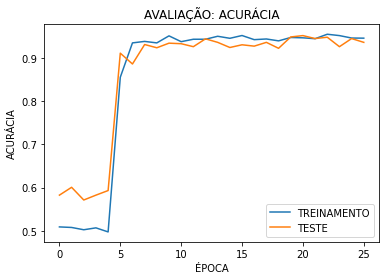

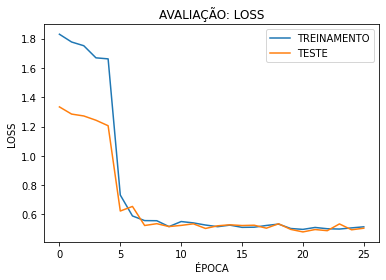

In [26]:
# GRÁFICO CONTENDO A INFORMAÇÃO DA ACURÁCIA
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('AVALIAÇÃO: ACURÁCIA')
plt.ylabel('ACURÁCIA')
plt.xlabel('ÉPOCA')
plt.legend(['TREINAMENTO', 'TESTE'], loc='best')
plt.show()

logging.info('GRÁFICO DE ACURÁCIA GERADO COM SUCESSO')

# GRÁFICO CONTENDO A INFORMAÇÃO DE LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AVALIAÇÃO: LOSS')
plt.ylabel('LOSS')
plt.xlabel('ÉPOCA')
plt.legend(['TREINAMENTO', 'TESTE'], loc='best')
plt.show()

logging.info('GRÁFICO DE LOSS GERADO COM SUCESSO')
logging.info('PROCESSO FINALIZADO')